In [1]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import *


In [1]:
def get_data_train(url):
    data_frame = pd.read_csv(url)
    return data_frame

In [3]:
def extract_variables(row):
    data = []
    for item in row:
        data.append(item)
    y,features = data[3],data[0:3]
    return (y,features)

In [4]:
def mapper_lr(row,bias=False):
    y,features = extract_variables(row)
    if bias==True:
        features.append(1.0)
    x = np.array(features)
    XX = np.outer(x,x)
    XY = x*y
    return ('XtX',XX),('XtY',XY)

In [5]:
def cholesky_solution_linear_regression(x_t_x, x_t_y):
    # L*L.T*Theta = x_t_y
    L = np.linalg.cholesky(x_t_x)
    #  solve L*z = x_t_y
    z = np.linalg.solve(L, x_t_y)
    #  solve L.T*Beta = z
    beta = np.linalg.solve(np.transpose(L), z)
    return beta

In [6]:
df = spark.read.option("header",True).option('inferSchema',True).csv("/home/hyminhlee/Desktop/spark-3.0.1-bin-hadoop3.2/LR Final/archive2/data_processed.csv")
df.collect()

[Row(genre=6.9894012269343655, type=2258, episodes=1.0, rating=9.37),
 Row(genre=6.86625282953957, type=3568, episodes=64.0, rating=9.26),
 Row(genre=6.756904073857389, type=3568, episodes=51.0, rating=9.25),
 Row(genre=7.043108056969871, type=3568, episodes=24.0, rating=9.17),
 Row(genre=6.756904073857389, type=3568, episodes=51.0, rating=9.16),
 Row(genre=6.886770242290035, type=3568, episodes=10.0, rating=9.15),
 Row(genre=6.874375700899778, type=3568, episodes=148.0, rating=9.13),
 Row(genre=6.843828441029535, type=3246, episodes=110.0, rating=9.11),
 Row(genre=6.756904073857389, type=2258, episodes=1.0, rating=9.1),
 Row(genre=6.756904073857389, type=3568, episodes=13.0, rating=9.11),
 Row(genre=6.881299788042139, type=3568, episodes=24.0, rating=9.06),
 Row(genre=7.003359037994927, type=2258, episodes=1.0, rating=9.05),
 Row(genre=6.756904073857389, type=3568, episodes=201.0, rating=9.04),
 Row(genre=6.837920185169405, type=3568, episodes=25.0, rating=8.98),
 Row(genre=6.88677024

In [7]:
distDF = df.rdd.flatMap(lambda row:mapper_lr(row))
distDF.collect()

[('XtX',
  array([[4.88517295e+01, 1.57820680e+04, 6.98940123e+00],
         [1.57820680e+04, 5.09856400e+06, 2.25800000e+03],
         [6.98940123e+00, 2.25800000e+03, 1.00000000e+00]])),
 ('XtY', array([6.54906895e+01, 2.11574600e+04, 9.37000000e+00])),
 ('XtX',
  array([[4.71454279e+01, 2.44987901e+04, 4.39440181e+02],
         [2.44987901e+04, 1.27306240e+07, 2.28352000e+05],
         [4.39440181e+02, 2.28352000e+05, 4.09600000e+03]])),
 ('XtY', array([   63.5815012, 33039.68     ,   592.64     ])),
 ('XtX',
  array([[4.56557527e+01, 2.41086337e+04, 3.44602108e+02],
         [2.41086337e+04, 1.27306240e+07, 1.81968000e+05],
         [3.44602108e+02, 1.81968000e+05, 2.60100000e+03]])),
 ('XtY', array([   62.50136268, 33004.        ,   471.75      ])),
 ('XtX',
  array([[4.96053711e+01, 2.51298095e+04, 1.69034593e+02],
         [2.51298095e+04, 1.27306240e+07, 8.56320000e+04],
         [1.69034593e+02, 8.56320000e+04, 5.76000000e+02]])),
 ('XtY', array([   64.58530088, 32718.56      

In [8]:
df2 = distDF.reduceByKey(lambda a,b: a+b)

In [9]:
df2.collect()

[('XtX',
  array([[5.22832161e+05, 2.11463471e+08, 9.89981242e+05],
         [2.11463471e+08, 9.60907558e+10, 4.99064945e+08],
         [9.89981242e+05, 4.99064945e+08, 2.80828900e+07]])),
 ('XtY', array([5.10969426e+05, 2.09129414e+08, 1.00796564e+06]))]

In [10]:
betas=[]
betas = cholesky_solution_linear_regression( df2.collect()[0][1],df2.collect()[1][1])

In [11]:
print(betas)

[8.84263808e-01 2.26825839e-04 6.89395998e-04]


In [12]:
# Tính predict dựa trên beta
df = df.withColumn("predict", col("genre")*betas[0]+col("type")*betas[1]+col("episodes")*betas[2])

In [13]:
df3 = df.select('rating','predict')
df3.collect()
#Kết quả

[Row(rating=9.37, predict=6.693336686010597),
 Row(rating=9.26, predict=6.9250148114868155),
 Row(rating=9.25, predict=6.81935951637407),
 Row(rating=9.17, predict=7.053825648473093),
 Row(rating=9.16, predict=6.81935951637407),
 Row(rating=9.15, predict=6.905930233104119),
 Row(rating=9.13, predict=6.990106836522433),
 Row(rating=9.11, predict=6.863860032236322),
 Row(rating=9.1, predict=6.487747868011595),
 Row(rating=9.11, predict=6.79316246843184),
 Row(rating=9.06, predict=6.910744452376455),
 Row(rating=9.05, predict=6.705679073174556),
 Row(rating=9.04, predict=6.922768916146035),
 Row(rating=8.98, predict=6.873074835536102),
 Row(rating=8.93, predict=6.916271173081316),
 Row(rating=8.93, predict=6.62262611896169),
 Row(rating=8.92, predict=6.82655015294443),
 Row(rating=8.88, predict=6.895951246563469),
 Row(rating=8.84, predict=6.448544734718003),
 Row(rating=8.83, predict=6.872895212291154),
 Row(rating=8.83, predict=6.930960994771699),
 Row(rating=8.83, predict=6.80816175740

In [14]:
def abs(value):
    return value if value > 0 else value*-1
#Mean Absolute Error
def cal_MAE(df):
    df = df.rdd.map(lambda a:abs(a[0]-a[1]))
    result = df.reduce(lambda a,b:a+b)
    result = result/df.count()
    return result
#Mean Squared Error
def cal_MSE(df):
    df = df.rdd.map(lambda a:(a[0]-a[1])*(a[0]-a[1]))
    result = df.reduce(lambda a,b:a+b)
    result = result/df.count()
    return result
#Root Mean Squared Error
def cal_RMSE(df):
    result = cal_MSE(df3)
    result = result**0.5
    return result

In [15]:
cal_MAE(df3)

0.7061688828910376

In [16]:
cal_MSE(df3)

0.8264562828343578

In [17]:
cal_RMSE(df3)

0.9090964100877078

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Genre vs Rating')

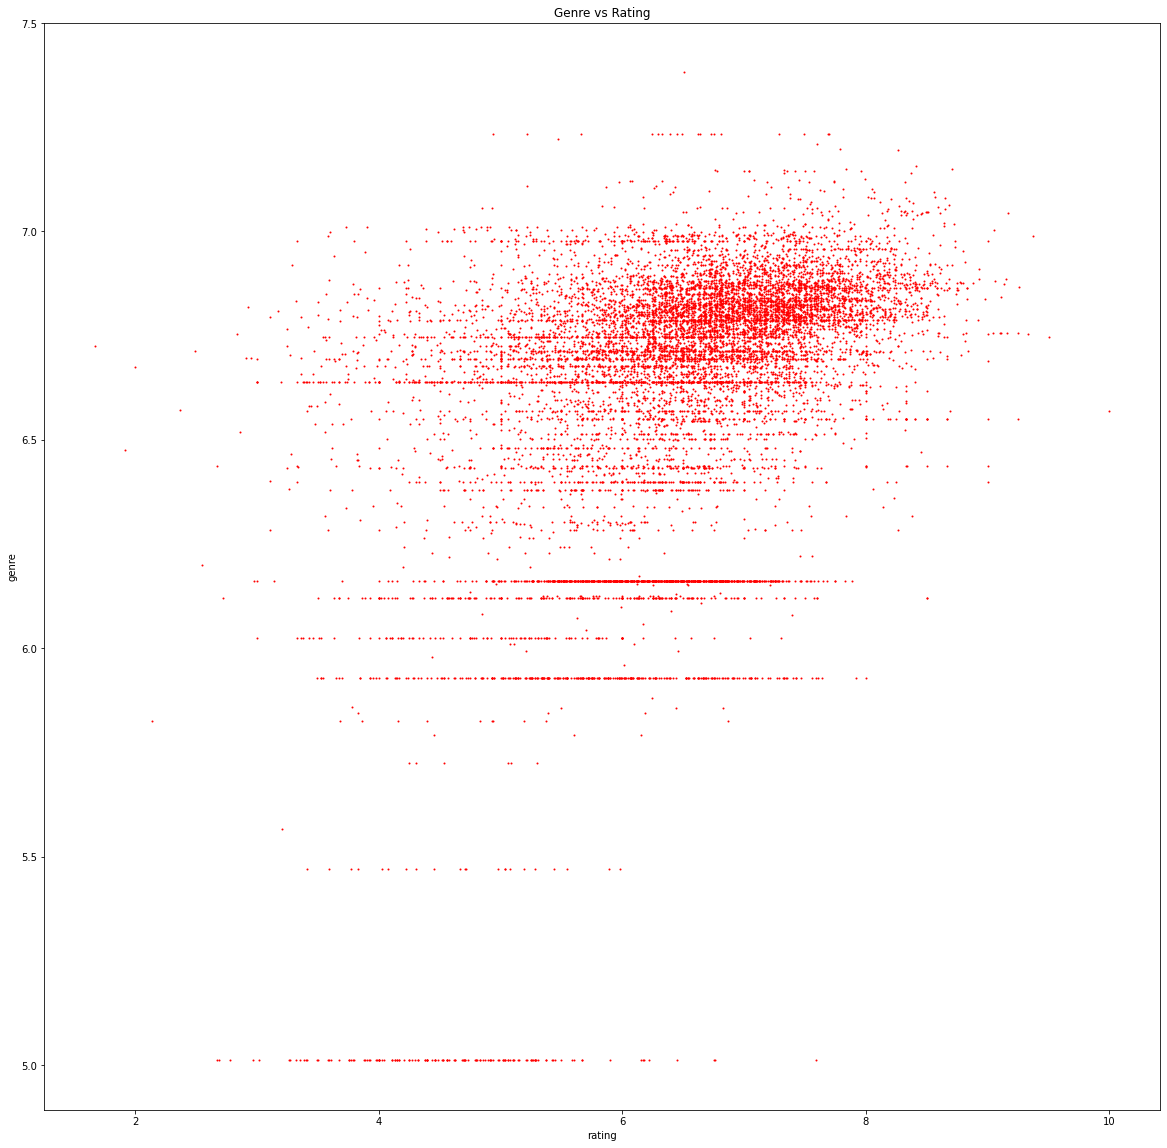

In [19]:
plt.figure(figsize=[20,20])
plt.plot(df.select('rating').collect(), df.select('genre').collect(), 'ro', markersize=1)
plt.ylabel("genre")
plt.xlabel("rating")
plt.title("Genre vs Rating")

Text(0.5, 1.0, 'Type vs Rating')

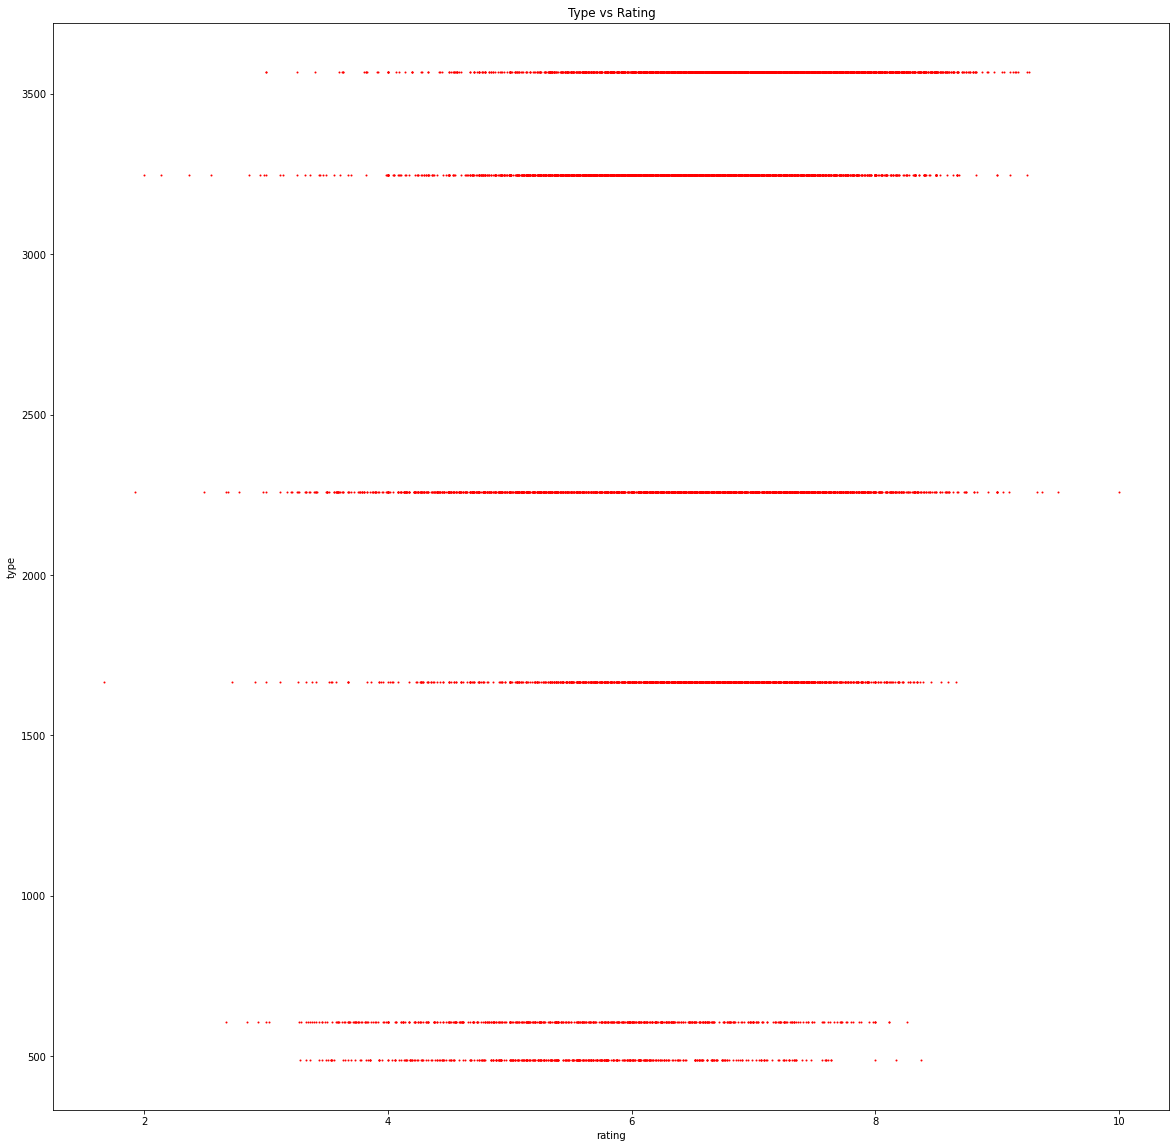

In [20]:
plt.figure(figsize=[20,20])
plt.plot(df.select('rating').collect(), df.select('type').collect(), 'ro', markersize=1)
plt.ylabel("type")
plt.xlabel("rating")
plt.title("Type vs Rating")

Text(0.5, 1.0, 'Episodes vs Rating')

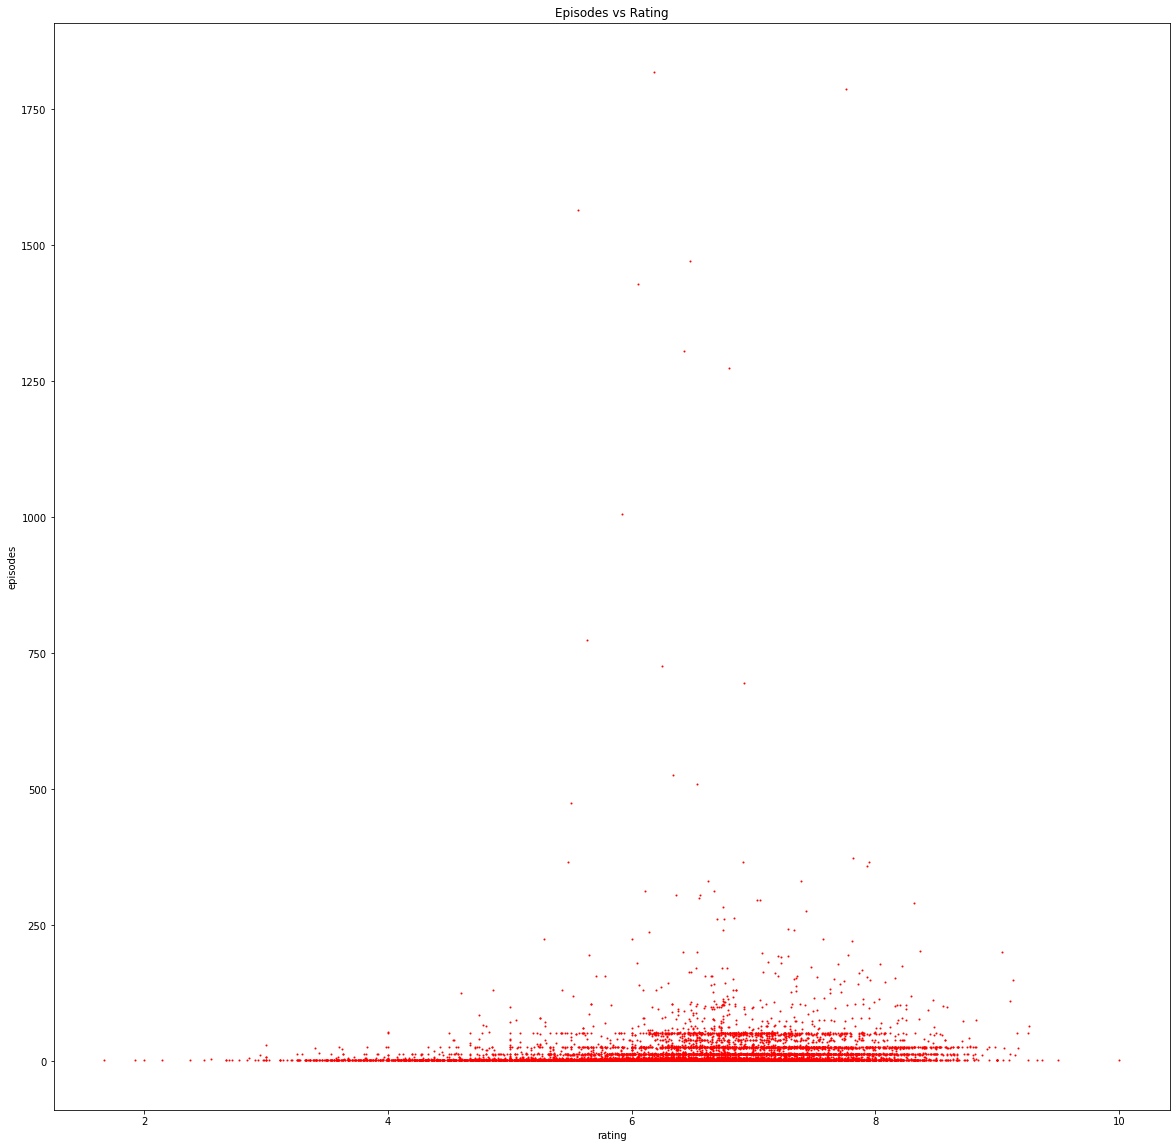

In [21]:
plt.figure(figsize=[20,20])
plt.plot(df.select('rating').collect(), df.select('episodes').collect(), 'ro', markersize=1)
plt.ylabel("episodes")
plt.xlabel("rating")
plt.title("Episodes vs Rating")

Text(0.5, 1.0, 'Predict vs Rating')

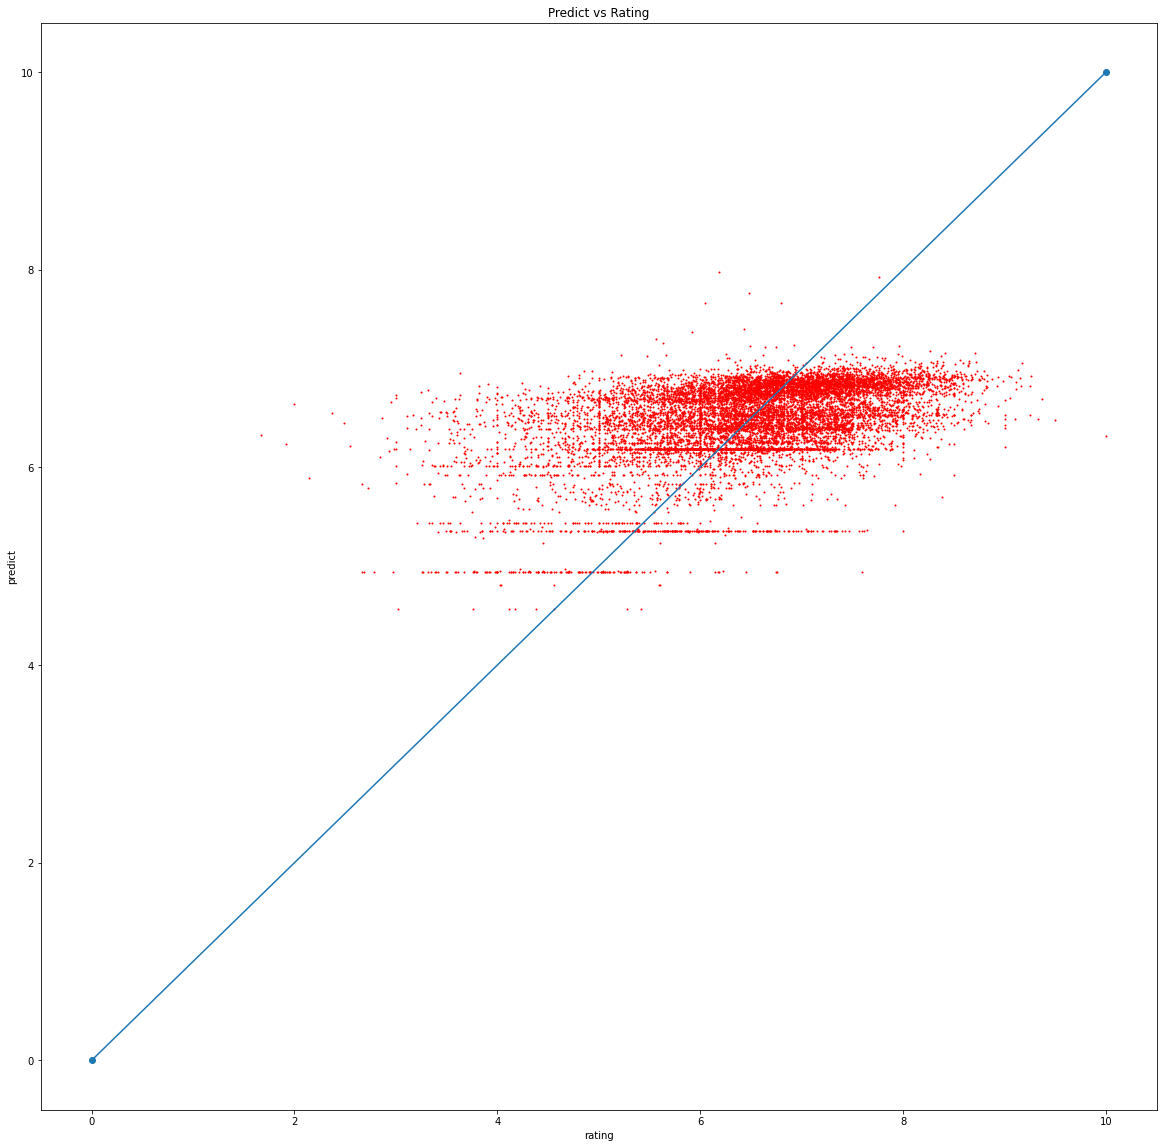

In [22]:
plt.figure(figsize=[20,20])
plt.plot(df.select('rating').collect(), df.select('predict').collect(), 'ro', markersize=1)
plt.plot([0,10],[0,10],marker='o')
plt.ylabel("predict")
plt.xlabel("rating")
plt.title("Predict vs Rating")

Text(0.5, 1.0, 'Genre vs Predict')

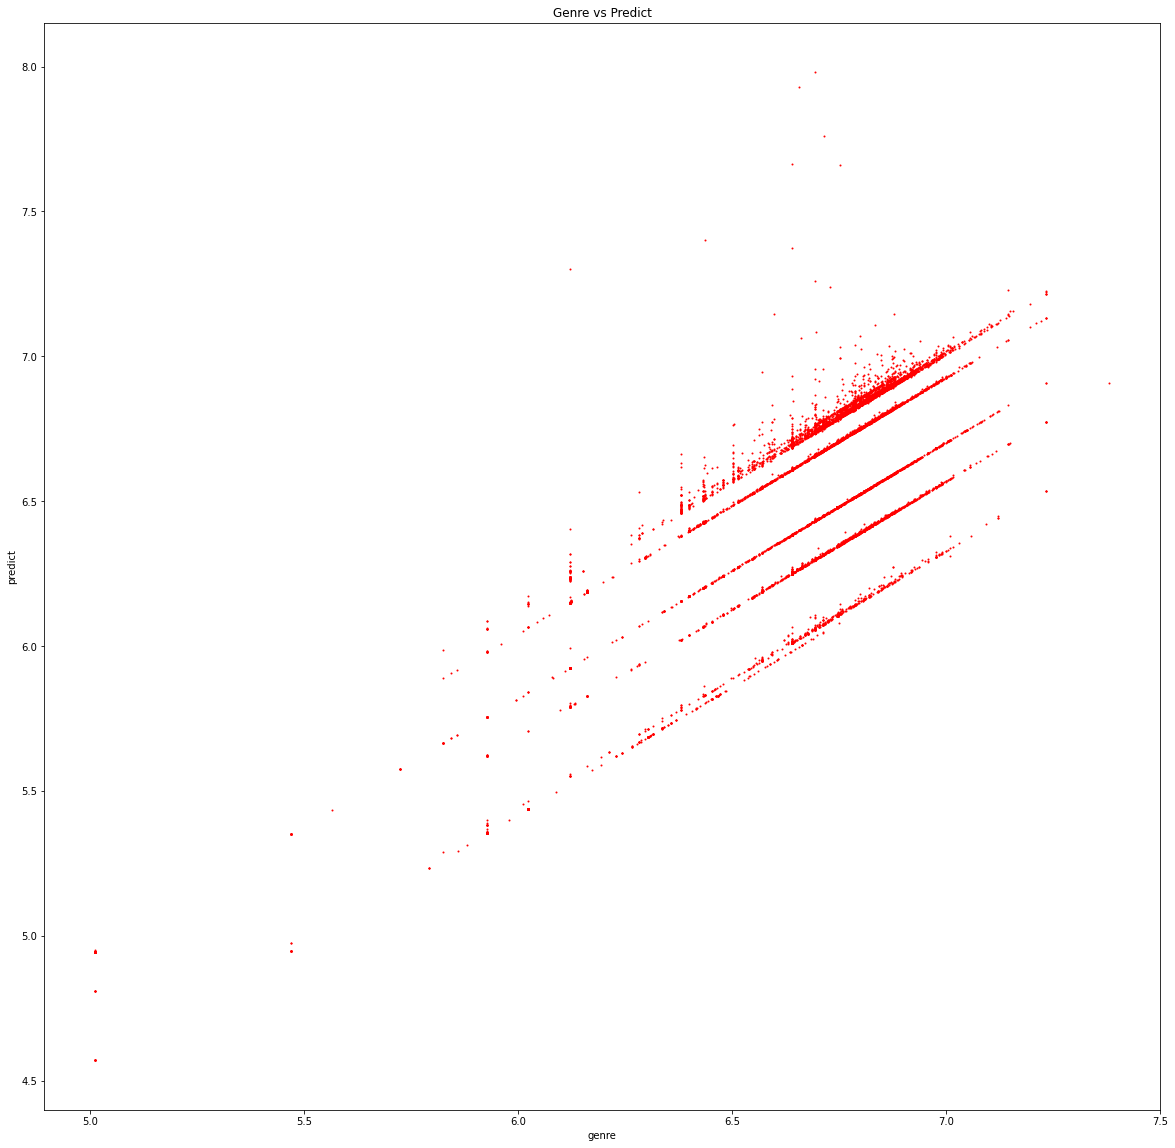

In [23]:
plt.figure(figsize=[20,20])
plt.plot(df.select('genre').collect(), df.select('predict').collect(), 'ro', markersize=1)
plt.ylabel("predict")
plt.xlabel("genre")
plt.title("Genre vs Predict")

Text(0.5, 1.0, '')

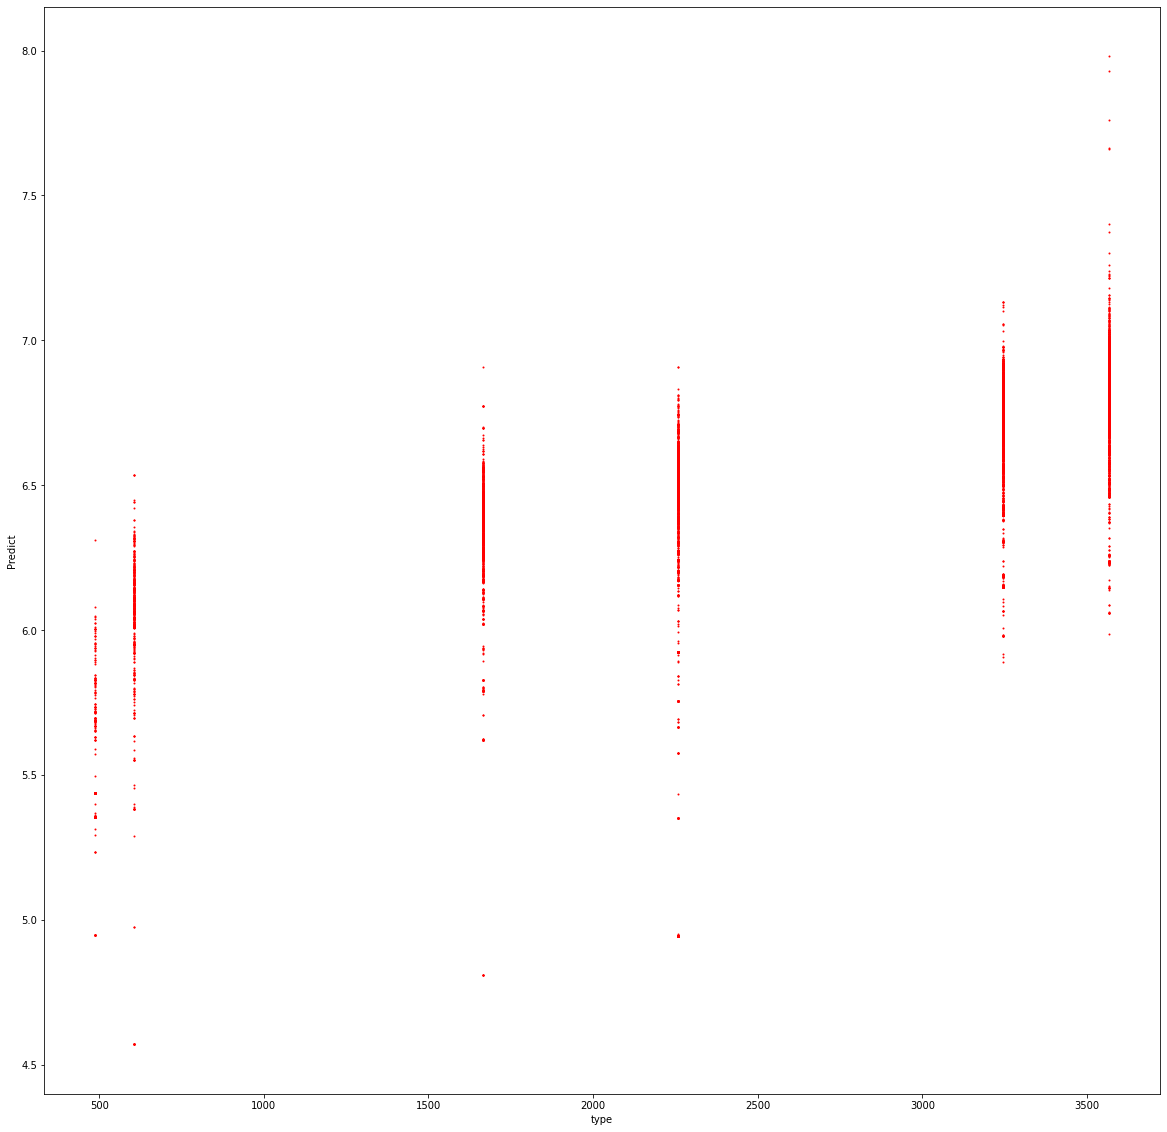

In [24]:
plt.figure(figsize=[20,20])
plt.plot(df.select('type').collect(), df.select('predict').collect(), 'ro', markersize=1)
plt.ylabel("Predict")
plt.xlabel("type")
plt.title("")

Text(0.5, 1.0, '')

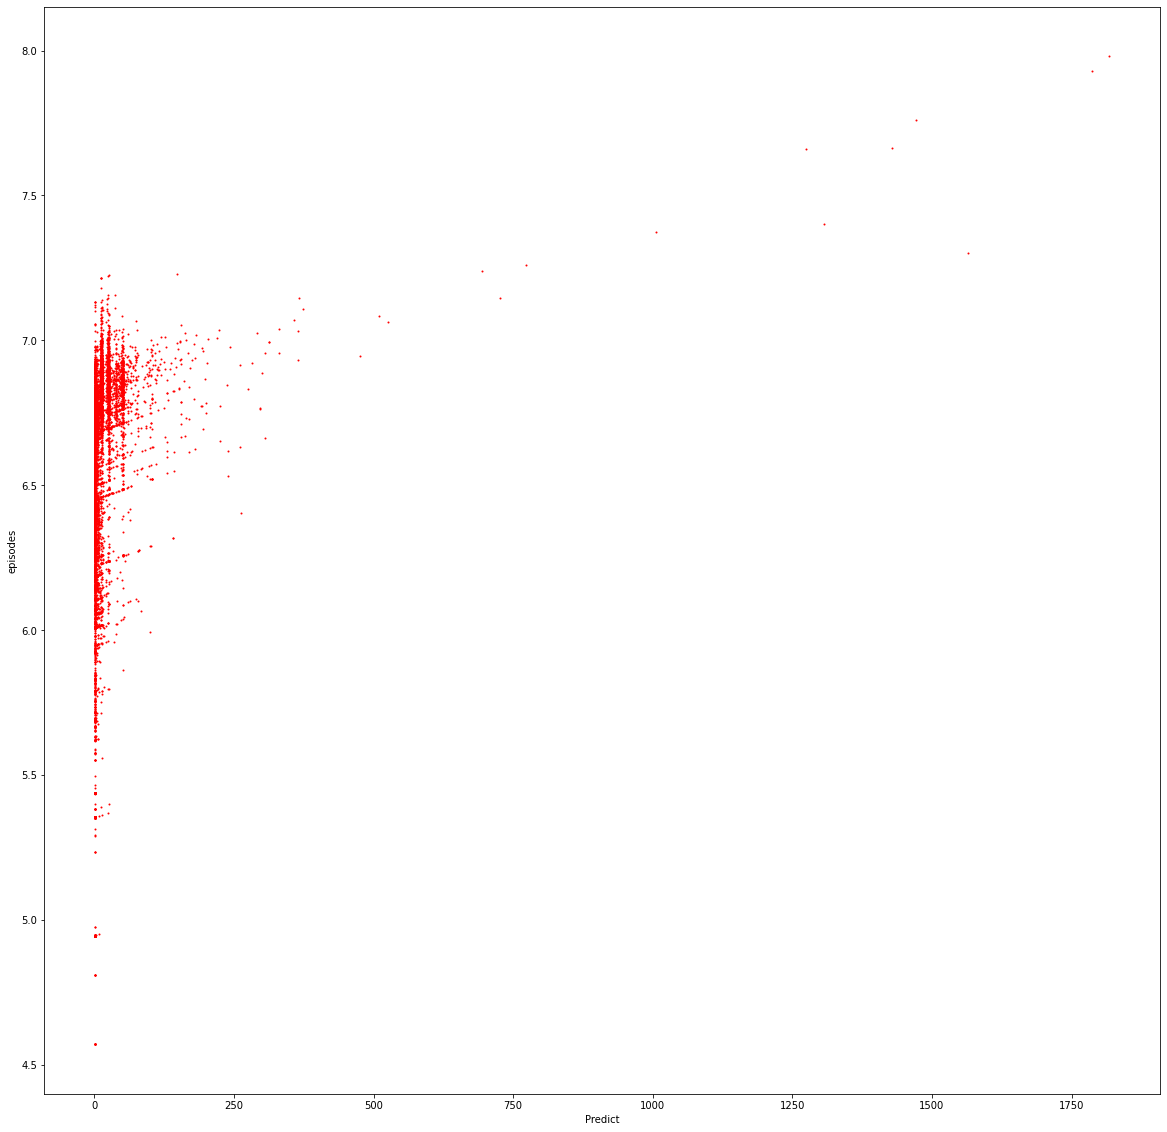

In [25]:
plt.figure(figsize=[20,20])
plt.plot(df.select('episodes').collect(), df.select('predict').collect(), 'ro', markersize=1)
plt.ylabel("episodes")
plt.xlabel("Predict")
plt.title("")

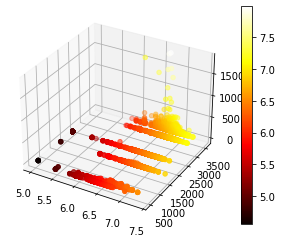

False

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

aa = df.select('genre').collect()
bb = df.select('type').collect()
cc = df.select('episodes').collect()
c = df.select('predict').collect()


img = ax.scatter(aa, bb, cc, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()
ax.can_zoom()

#Predict 4d

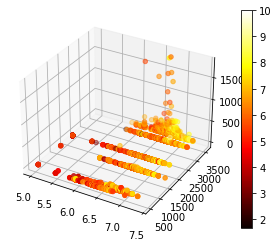

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df.select('genre').collect()
y = df.select('type').collect()
z = df.select('episodes').collect()
c = df.select('rating').collect()


img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

#Rating 4d